# Short-term demand forecasting

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from prophet import Prophet
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

/Users/irina/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/irina/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [7]:
# Reading files
path = '/Users/irina/Desktop/Brazilian_E-Commerce_by_Olist/'
files = ['orders', 'order_items', 'products', 'product_category_name_translation']
for file in files:
    file_path = path + file + '.csv' 
    globals()[file] = pd.read_csv(file_path)

In [8]:
# Leaving the necessary columns
order_items = order_items[['order_id', 'product_id']]
products = products[['product_id', 'product_category_name']]
orders = orders[['order_id', 'order_purchase_timestamp']]
# Formatting date column
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_purchase_timestamp'] = orders['order_purchase_timestamp'].dt.date

In [10]:
# Merging tables
merged = pd.merge(order_items, orders, how = 'left', left_on = 'order_id', right_on = 'order_id' )
merged = pd.merge(merged, products, how = 'left', left_on = 'product_id', right_on = 'product_id')
# Deleting product_ids with no product_category_name
merged = merged.dropna()
data = pd.merge(merged, product_category_name_translation, how = 'left', left_on = 'product_category_name', right_on = 'product_category_name')


In [12]:
# Creating table with date, product_category, quantity columns
data = data[['order_purchase_timestamp', 'product_category_name_english']]
data.columns = ['date', 'product_category']
data = data.groupby(['date', 'product_category']).size().reset_index(name='quantity')

In [13]:
data.head()

,date,product_category,quantity
0,2016-09-04,furniture_decor,2
1,2016-09-05,telephony,1
2,2016-09-15,health_beauty,3
3,2016-10-02,baby,1
4,2016-10-03,fashion_shoes,1


In [15]:
# Little data for 2016 and anomalous data for 09.2018. Deleting these parts of data
data['date'] = pd.to_datetime(data['date'])
data = data[(data['date'] >= '2017-01-01')]
data = data[(data['date'] <= '2018-08-20')]

<AxesSubplot:xlabel='date'>

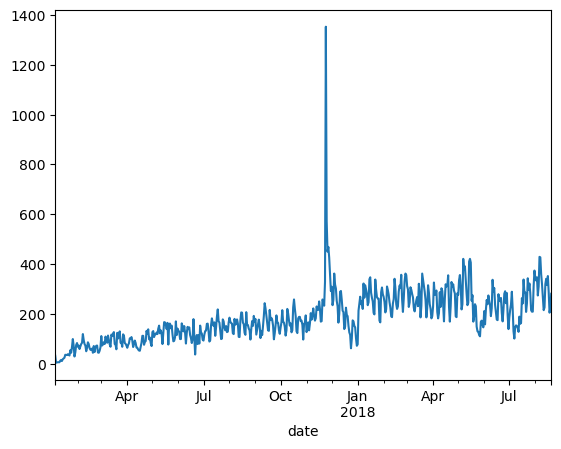

In [19]:
# Graph of the quantity of all product categories from 2017-01-01 to 2018-08-20
data_indx = data.set_index('date', drop = True)
grouped_data = data_indx.groupby(data_indx.index)['quantity'].sum()
grouped_data.plot()

The graph shows the peak of sales, which occurs on Black Friday 24.11.2017. The general trend is increasing.

In [20]:
# Plotting the time series and its autocorrelation and partial autocorrelation functions
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Original')
        ts_ax.set_title('Original')

        sm.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        sm.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

Combined Time Series Analysis:


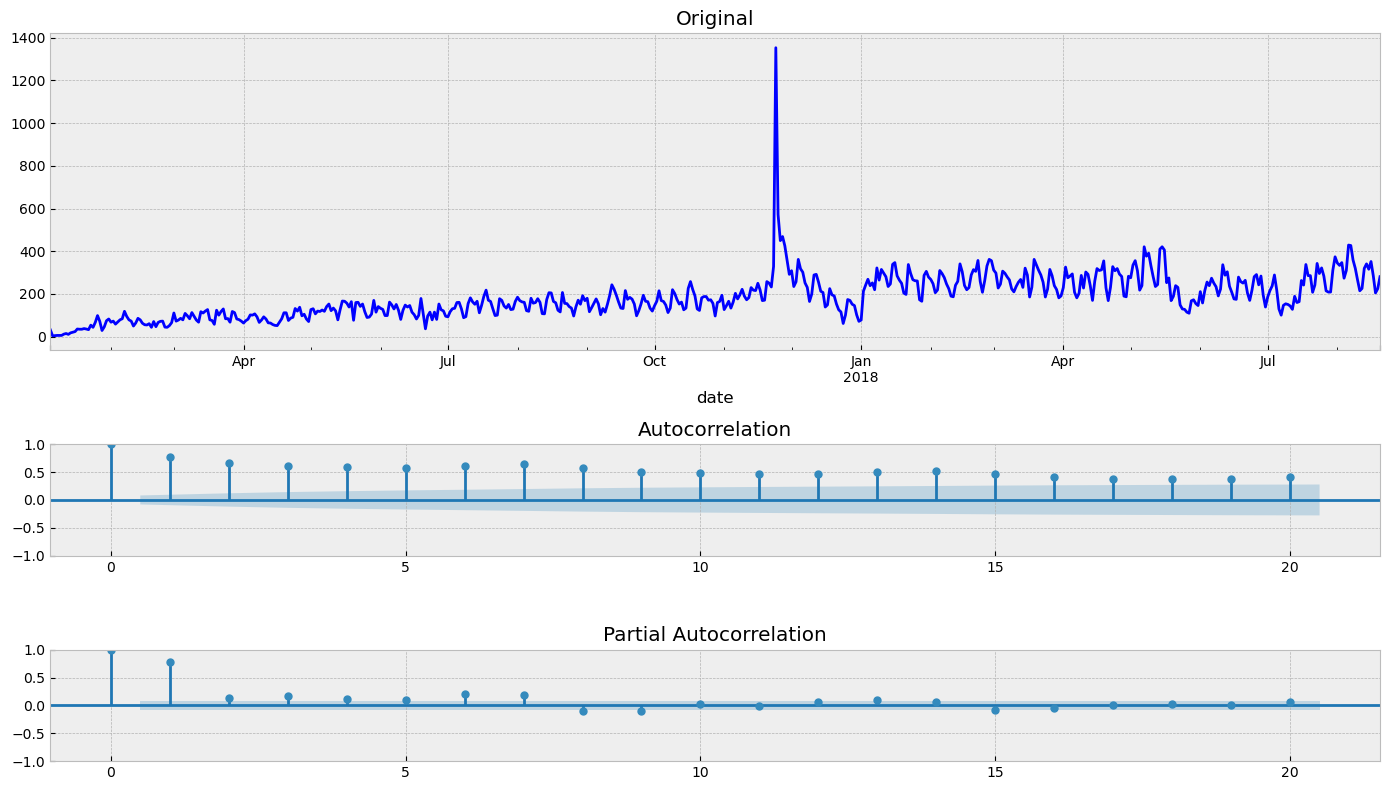

In [21]:
grouped_data = data.groupby('date')['quantity'].sum()
print("Combined Time Series Analysis:")
tsplot(grouped_data, lags=20)
plt.show()

Weekly seasonality is seen in the graph.

Let's see the most selled categories.

In [22]:
data.groupby('product_category')['quantity'].sum().sort_values(ascending = False)

product_category
bed_bath_table               11016
health_beauty                 9487
sports_leisure                8541
furniture_decor               8223
computers_accessories         7752
                             ...  
cds_dvds_musicals               14
la_cuisine                      14
gaming_pc                        9
fashion_childrens_clothes        8
security_and_services            2
Name: quantity, Length: 73, dtype: int64

## Health category data

I chose 2nd most selling category (health_beauty) for forecasting.

In [23]:
# Creating table for health_beauty data with date, quantity columns
health = data[data['product_category']=='health_beauty']
health = health.drop('product_category', axis = 1)

In [24]:
health.head()

,date,quantity
143,2017-01-06,1
147,2017-01-07,1
156,2017-01-09,1
183,2017-01-13,2
197,2017-01-15,1


<AxesSubplot:xlabel='date'>

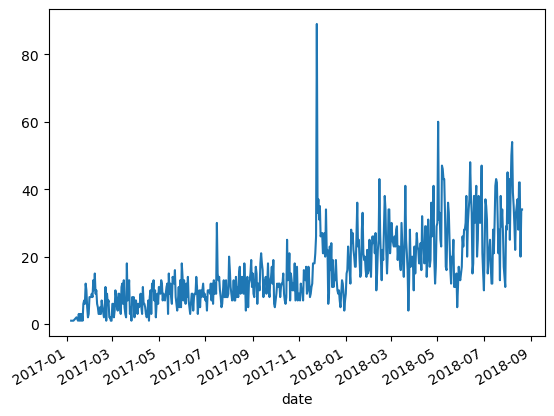

In [25]:
# Plotting health data
data_indx = health.set_index('date', drop = True)
grouped_data = data_indx.groupby(data_indx.index)['quantity'].sum()
grouped_data.plot()

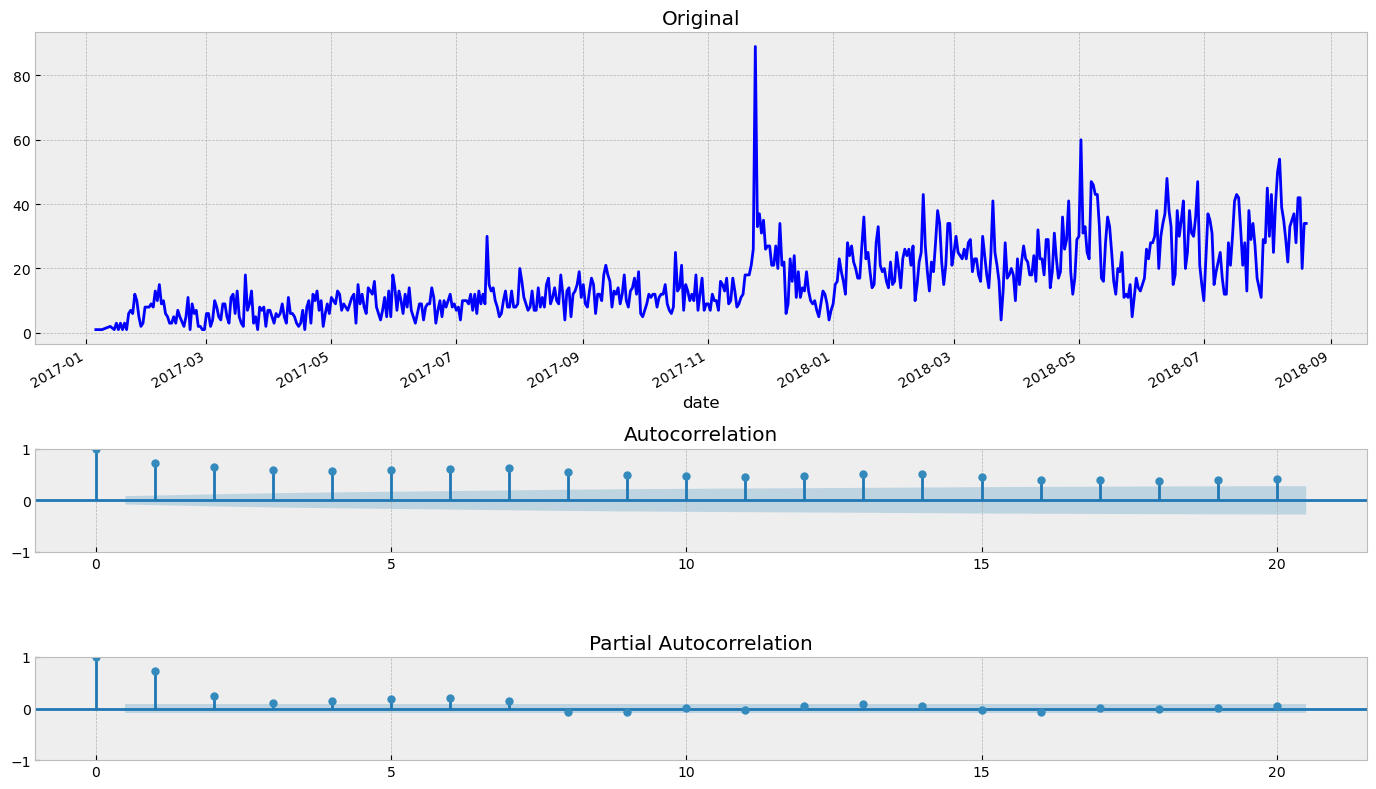

In [26]:
grouped_health = health.groupby('date')['quantity'].sum()
tsplot(grouped_health, lags=20)
plt.show()

Weekly seasonality is also seen in the graph for health_beauty category.

In [27]:
# For several days there were no sales in health category, that's why some dates are missing
# Creating a DataFrame with all dates
start_date = health['date'].min()
end_date = health['date'].max()
all_dates = pd.date_range(start=start_date, end=end_date, freq='D')
all_dates_df = pd.DataFrame({'date': all_dates})

# Merging with original data, filling missing dates with 0 quantities
health_full = all_dates_df.merge(health, on='date', how='left')
health_full['quantity'].fillna(0, inplace=True)

In [28]:
health_full.head()

,date,quantity
0,2017-01-06,1.0
1,2017-01-07,1.0
2,2017-01-08,0.0
3,2017-01-09,1.0
4,2017-01-10,0.0


## Creating a baseline forecast using Prophet

In [30]:
health_prophet = health_full.copy()
health_prophet.columns  = ['ds', 'y']

# Splitting the data
predictions = 14
train_pr = health_prophet[:-predictions]
test_pr = health_prophet[-predictions:]

In [31]:
# Initializing and fitting Prophet model
model_pr = Prophet()
model_pr.fit(train_pr)

15:24:43 - cmdstanpy - INFO - Chain [1] start processing
15:24:43 - cmdstanpy - INFO - Chain [1] done processing


In [32]:
# Making forecasts
future_dates_pr = model_pr.make_future_dataframe(periods=predictions)
forecast_pr = model_pr.predict(future_dates_pr)
forecasted_data_pr = forecast_pr[-predictions:]

In [33]:
# Extracting actual values for the test period
actual_data_pr = test_pr.set_index('ds')['y']

In [34]:
# Function to calculate mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    abs_pct_error = np.abs((y_true - y_pred) / y_true)
    mape = np.nanmean(abs_pct_error) * 100
    return mape

In [35]:
# Evaluating forecast
mae_pr = mean_absolute_error(actual_data_pr, forecasted_data_pr['yhat'])
print(f"Mean Absolute Error (MAE): {mae_pr:.2f}")
mse_pr = mean_squared_error(actual_data_pr, forecasted_data_pr['yhat'])
rmse_pr = mse_pr**0.5
print(f"Root Mean Squared Error (RMSE): {rmse_pr:.2f}")
mape_pr = mean_absolute_percentage_error(actual_data_pr, forecasted_data_pr['yhat'])
print(f"Mean Absolute Percentage Error (MAPE): {mape_pr:.2f}")

Mean Absolute Error (MAE): 6.65
Root Mean Squared Error (RMSE): 8.61
Mean Absolute Percentage Error (MAPE): 18.00


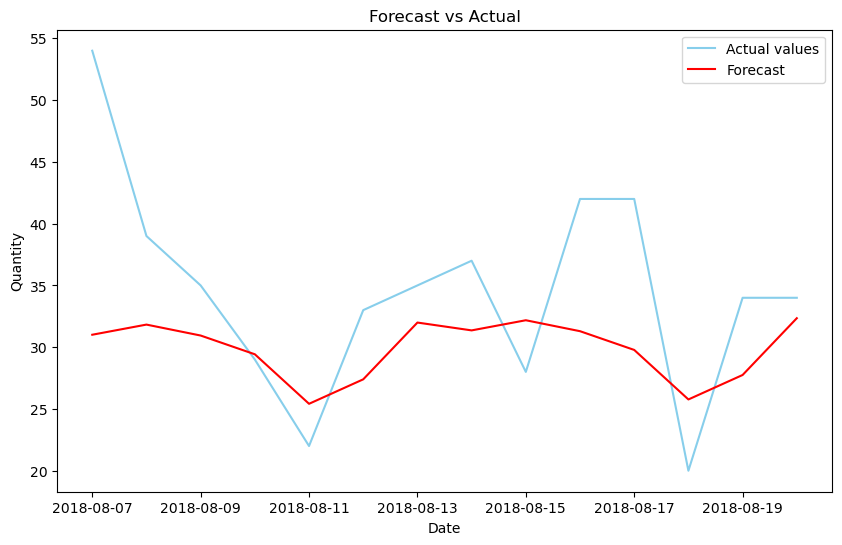

In [36]:
# Plotting forecasted and actual values
plt.figure(figsize=(10, 6))
plt.plot(actual_data_pr.index, actual_data_pr.values, label='Actual values', color='skyblue')
plt.plot(forecasted_data_pr['ds'], forecasted_data_pr['yhat'], label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Forecast vs Actual')
plt.legend()
plt.show()

## Gradient Boosting 

For machine learning model I chose Gradient Boosting to use ensemble learning technique advantages. This model can capture complex nonlinear relationships between features and the target variable. It is usually a preferred choice of ML model for time series forecasting.

In [39]:
health_gb = health_full.copy()

# Extracting date-related features
health_gb['year'] = health_gb['date'].dt.year
health_gb['month'] = health_gb['date'].dt.month
health_gb['day'] = health_gb['date'].dt.day
health_gb['weekday'] = health_gb['date'].dt.weekday  # Monday: 0, Sunday: 6
health_gb['weekofyear'] = health_gb['date'].apply(lambda x: x.isocalendar()[1])

In [40]:
health_gb.head()

,date,quantity,year,month,day,weekday,weekofyear
0,2017-01-06,1.0,2017,1,6,4,1
1,2017-01-07,1.0,2017,1,7,5,1
2,2017-01-08,0.0,2017,1,8,6,1
3,2017-01-09,1.0,2017,1,9,0,2
4,2017-01-10,0.0,2017,1,10,1,2


In [41]:
# Adding Lag Features (Shifts) assuming weekly seasonality
num_lags = 7
for i in range(1, num_lags + 1):
    health_gb[f'quantity_lag_{i}'] = health_gb['quantity'].shift(i)
health_gb = health_gb.dropna()

In [42]:
# Forming train and test datasets
X_gb = health_gb.drop(['date', 'quantity'], axis=1)
y_gb = health_gb['quantity']

def timeseries_train_test_split(X, y, test_size_days):
    X_train, X_test = X.iloc[:-test_size_days], X.iloc[-test_size_days:]
    y_train, y_test = y.iloc[:-test_size_days], y.iloc[-test_size_days:]
    return X_train, X_test, y_train, y_test

X_train_gb, X_test_gb, y_train_gb, y_test_gb = timeseries_train_test_split(X_gb,y_gb,14)

In [43]:
# Initializing and fitting Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
gb_model.fit(X_train_gb, y_train_gb)
y_pred_gb = gb_model.predict(X_test_gb)

In [44]:
# Evaluating forecast
mae_gb = mean_absolute_error(y_test_gb, y_pred_gb)
print(f"Mean Absolute Error (MAE): {mae_gb:.2f}")
mse_gb = mean_squared_error(y_test_gb, y_pred_gb)
rmse_gb = mse_gb**0.5
print(f"Root Mean Squared Error (RMSE): {rmse_gb:.2f}")
mape_gb = mean_absolute_percentage_error(y_test_gb, y_pred_gb)
print(f"Mean Absolute Percentage Error (MAPE): {mape_gb:.2f}")

Mean Absolute Error (MAE): 5.71
Root Mean Squared Error (RMSE): 7.56
Mean Absolute Percentage Error (MAPE): 15.60


In [45]:
X_test_dates_gb = X_test_gb.copy()
X_test_dates_gb['date'] = pd.to_datetime(X_test_gb[['year', 'month', 'day']])

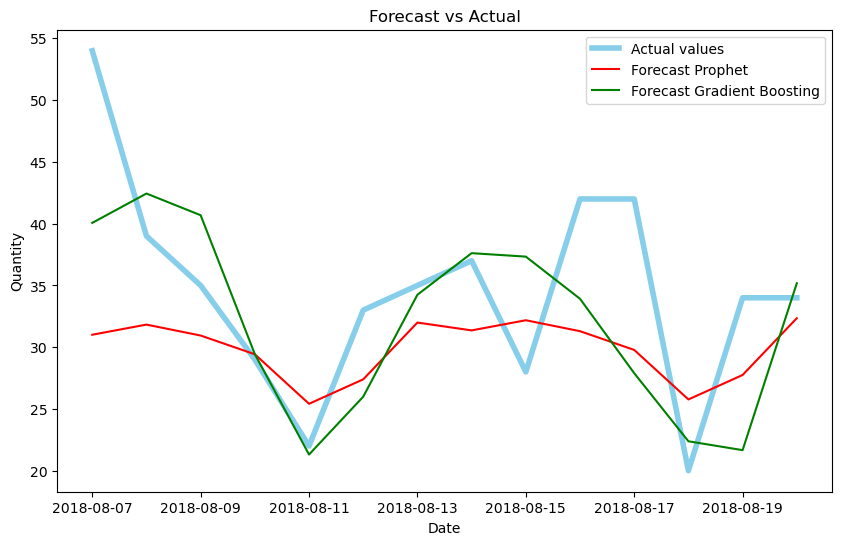

In [46]:
# Plotting forecasted and actual values
plt.figure(figsize=(10, 6))
plt.plot(X_test_dates_gb['date'], y_test_gb.values, label='Actual values', color='skyblue', linewidth=4)
plt.plot(forecasted_data_pr['ds'], forecasted_data_pr['yhat'], label='Forecast Prophet', color='red')
plt.plot(X_test_dates_gb['date'], y_pred_gb, label='Forecast Gradient Boosting', color='green')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Forecast vs Actual')
plt.legend()
plt.show()

## SARIMA

For classical time series forecasting Exponential Smoothing or Moving Average can be used. Basic MA or ES are used when there is no trend or seasonality in the data. Our data clearly has trend and at least week seasonality, it's better to use SARIMA, as this metod can capture seasonality and trends effectively. But ARIMA models can be hard in tuning.

In [47]:
health_sarima = health_full.copy()

# Splitting the data
predictions = 14
train_df_ma = health_sarima[:-predictions]
test_df_ma = health_sarima[-predictions:]

train_df_ma.set_index('date', inplace=True)

In [48]:
# Initializing and fitting SARIMA model
sarima_model = SARIMAX(train_df_ma['quantity'], order=(1, 0, 1), seasonal_order=(1, 0, 1, 7))
result_ma = sarima_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.40708D+00    |proj g|=  1.53522D-01

At iterate    5    f=  3.29677D+00    |proj g|=  3.63643D-03

At iterate   10    f=  3.28964D+00    |proj g|=  5.64683D-03

At iterate   15    f=  3.28847D+00    |proj g|=  2.37575D-03


 This problem is unconstrained.



At iterate   20    f=  3.28807D+00    |proj g|=  2.87736D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     27      1     0     0   2.618D-06   3.288D+00
  F =   3.2880517172364230     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [49]:
# Forecasting
forecast_days = 14
forecast_ma = result_ma.get_forecast(steps=forecast_days)
forecast_values_ma = forecast_ma.predicted_mean

In [50]:
# Evaluating forecast
mae_ma = mean_absolute_error(test_df_ma['quantity'], forecast_values_ma)
print(f"Mean Absolute Error (MAE): {mae_ma:.2f}")
mse_ma = mean_squared_error(test_df_ma['quantity'], forecast_values_ma)
rmse_ma = mse_ma**0.5
print(f"Root Mean Squared Error (RMSE): {rmse_ma:.2f}")
mape_ma = mean_absolute_percentage_error(test_df_ma['quantity'], forecast_values_ma)
print(f"Mean Absolute Percentage Error (MAPE): {mape_ma:.2f}")

Mean Absolute Error (MAE): 5.70
Root Mean Squared Error (RMSE): 6.79
Mean Absolute Percentage Error (MAPE): 16.75


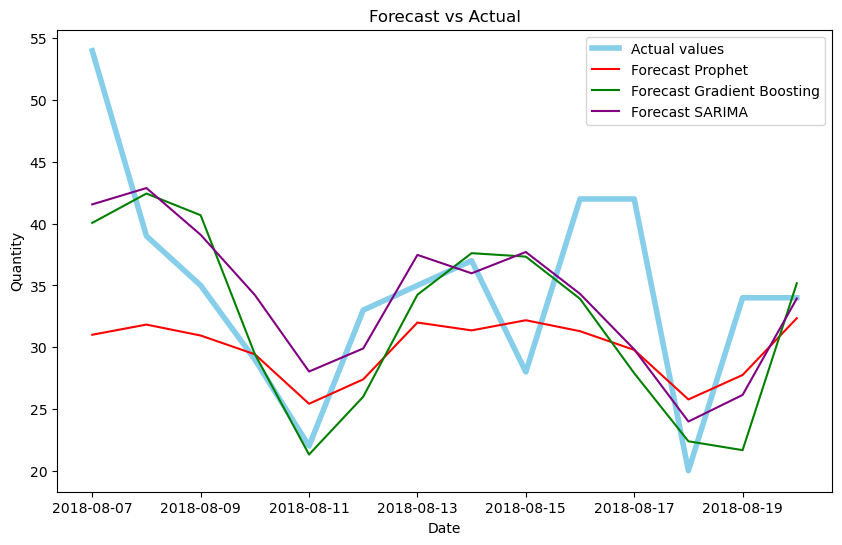

In [51]:
# Plotting forecasted and actual values
plt.figure(figsize=(10, 6))
plt.plot(X_test_dates_gb['date'], y_test_gb.values, label='Actual values', color='skyblue', linewidth=4)
plt.plot(forecasted_data_pr['ds'], forecasted_data_pr['yhat'], label='Forecast Prophet', color='red')
plt.plot(X_test_dates_gb['date'], y_pred_gb, label='Forecast Gradient Boosting', color='green')
plt.plot(X_test_dates_gb['date'], forecast_values_ma, label='Forecast SARIMA', color='purple')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Forecast vs Actual')
plt.legend()
plt.show()

## Forecasting for different product categories

As Gradient Boosting showed the best results forecasting for one category, let's use it to make predictions for other categories, assuming that patterns of sales for different categories are similar.

In [52]:
data.groupby('product_category')['quantity'].sum().sort_values(ascending = False)

product_category
bed_bath_table               11016
health_beauty                 9487
sports_leisure                8541
furniture_decor               8223
computers_accessories         7752
                             ...  
cds_dvds_musicals               14
la_cuisine                      14
gaming_pc                        9
fashion_childrens_clothes        8
security_and_services            2
Name: quantity, Length: 73, dtype: int64

In [53]:
def forecast(category, days):
    """
    Forecast the quantity of a product category using a Gradient Boosting model.

    Parameters:
    - category (str): The product category for which to forecast the quantity.
    - days (int): The amount of days for forecasting.

    Returns:
    - y_pred (array): Predicted quantity values for the given product category.

    This function prepares the data for forecasting by filling missing dates, extracting date-related features,
    adding lag features to account for weekly seasonality, and training a Gradient Boosting model on the prepared data.
    It then uses the trained model to predict the quantity for the specified product category.
    """
    # Selecting data for category
    df = data[data['product_category']==category]
    df = df.drop('product_category', axis = 1)
    # Creating a DataFrame with all dates
    start_date = df['date'].min()
    end_date = df['date'].max()
    all_dates = pd.date_range(start=start_date, end=end_date, freq='D')
    all_dates_df = pd.DataFrame({'date': all_dates})
    df_full = all_dates_df.merge(df, on='date', how='left')
    df_full['quantity'].fillna(0, inplace=True)
    # Extracting date-related features
    df_full['year'] = df_full['date'].dt.year
    df_full['month'] = df_full['date'].dt.month
    df_full['day'] = df_full['date'].dt.day
    df_full['weekday'] = df_full['date'].dt.weekday  # Monday: 0, Sunday: 6
    df_full['weekofyear'] = df_full['date'].apply(lambda x: x.isocalendar()[1])
    # Adding Lag Features (Shifts) assuming weekly seasonality
    for i in range(1, 8):
        df_full[f'quantity_lag_{i}'] = df_full['quantity'].shift(i)
    df_full = df_full.dropna()
    # Forming X and y
    X_gb = df_full.drop(['date', 'quantity'], axis=1)
    y_gb = df_full['quantity']
    # Creating X_test from number of days for forecast
    end_date_plus_one = df_full['date'].max() + pd.Timedelta(days=1)
    future_dates = pd.date_range(start=end_date_plus_one, periods=days, freq='D')
    X_test = pd.DataFrame({'date': future_dates})
    X_test['year'] = X_test['date'].dt.year
    X_test['month'] = X_test['date'].dt.month
    X_test['day'] = X_test['date'].dt.day
    X_test['weekday'] = X_test['date'].dt.weekday
    X_test['weekofyear'] = X_test['date'].apply(lambda x: x.isocalendar()[1])
    for i in range(1, 8):
        X_test[f'quantity_lag_{i}'] = df_full['quantity'].shift(i).iloc[-1]
    # Drop the 'date' column from X_test
    X_test = X_test.drop('date', axis=1)
    # Initializing and fitting Gradient Boosting model
    gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
    gb_model.fit(X_gb, y_gb)
    y_pred = gb_model.predict(X_test)
    return y_pred

Let's try this function on bed_bath_table category.

In [54]:
y_pred = forecast('bed_bath_table', 14)

In [55]:
y_pred

array([27.24090015, 27.42352031, 27.28556092, 22.29813666, 21.89020049,
       21.89020049, 28.19798944, 26.97567397, 27.5530815 , 27.58230092,
       22.86010284, 22.26778985, 22.26778985, 29.72321211])

## Demand forecast for new products

The idea is to use cosine similarity to find similar product, that already has sales data, predict new product's demand based on it.

In [57]:
products_sim = pd.read_csv(path + 'products.csv' )
products_sim = products_sim.dropna()

In [58]:
def find_similar_products(new_product, products_df):

    # Drop 'product_id' and 'product_category_name' columns
    features_df = products_df.drop(['product_id', 'product_category_name'], axis=1)

    # Normalize the feature columns
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features_df)
    scaled_new_product_features = scaler.transform(new_product.values)
    
    # Compute cosine similarity
    similarities = cosine_similarity(scaled_new_product_features, scaled_features)

    # Get indices of products sorted by similarity (excluding the new product itself)
    similar_product_indices = similarities.argsort()[0][::-1][1:]

    # Return indices of similar products
    return similar_product_indices

Let's try this function on some random combination of features as new product

In [60]:
dataLists = [[41, 288, 1, 226, 17, 11, 15]]
headers =['product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 
          'product_length_cm', 'product_height_cm', 'product_width_cm']
new_product = pd.DataFrame(dataLists, columns=headers)

In [61]:
similar_product_indices = find_similar_products(new_product, products_sim)
similar_products = products_sim.iloc[similar_product_indices]

In [62]:
similar_products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
5863,7670134d0deed66c4befad4f59d0af49,utilidades_domesticas,41.0,243.0,1.0,400.0,16.0,11.0,14.0
3320,a2246862425c12496bad1be2082015ab,automotivo,41.0,244.0,1.0,398.0,18.0,10.0,15.0
9639,7f6a27bc434791d71f6e52b25bfc1e9e,papelaria,42.0,236.0,1.0,100.0,16.0,10.0,15.0
26899,c4ab5e7b0c00f3b99fc11847a619b88e,pet_shop,41.0,307.0,1.0,50.0,20.0,11.0,16.0
4526,2be7c0f7dd57742c970f856ec64bc25e,informatica_acessorios,41.0,317.0,1.0,200.0,18.0,9.0,16.0


Now knowing similar products, we can try using the same forecast for new product as for similar product, while new product doesn't have its own data.